In [3]:
import torch
import torch.nn as nn
from torch.distributions import normal
from torch.distributions import uniform
import matplotlib.pyplot as plt

In [122]:
torch.manual_seed(1)
class CUDAvoir(nn.Module):
    def __init__(self,n,p,sig,o=0.0,bias=True):
        super(CUDAvoir,self).__init__()

        self.n = torch.tensor(n)
        self.p = torch.tensor(p)
        self.sig = torch.tensor(sig)

        self.v = torch.zeros(self.n) ## Recurrent Layer State Vector
        self.w = torch.zeros(self.n,self.n) ## Recurrent Layer Weight Matrix

        self.ol = nn.Linear(self.n, 1, bias=False) ## Linear Output Layer
        self.o = torch.tensor([o]) ## Initalize Output Neuron
        self.fb = nn.Linear(1, self.n, bias=False) ## Linear Feedback Layer
        self.fb.weight.requires_grad_(False)

        if bias: ## Recurrent Layer Bias
            self.b = torch.FloatTensor(n).uniform_(0,1)
        else:
            self.b = torch.zeros(self.n)
        
        ## Populate Recurrent Layer Weight Matrix
        norm = normal.Normal(loc=0,scale=self.sig)
        uni = uniform.Uniform(0,1) 
        for i in range(self.n):
            for j in range(self.n):
                uni_draw = uni.sample()
                if uni_draw < self.p:
                    self.w[i,j] = norm.sample()
    
    def forward(self):
        z = torch.matmul(self.w,self.v) + self.fb(self.o) + self.b
        nl = nn.Tanh()
        y = nl(z)
        self.v = y
        self.o = self.ol(y)
        return self.v, self.o

In [93]:
#torch.manual_seed(1)
n, p, sig = 100, 0.3, 0.3
m = CUDAvoir(n,p,sig)

lr = 0.02
targ = torch.sin
dt = 0.05
steps = 500

targs = []
outs = []
errs = []

for s in range(steps):
    y,o = m.forward()
    outs.append(o)
    diff = o - targ(torch.tensor(dt*s))
    errs.append(diff)
    targs.append(targ(torch.tensor([dt*s])))
    
    rms = diff.pow(2)
    rms.backward(retain_graph=True)
    ol = m.ol.weight.detach()
    ol_g = m.ol.weight.grad
    nw = (ol - lr*ol_g).clone().detach()
    m.ol.weight = nn.Parameter(nw)

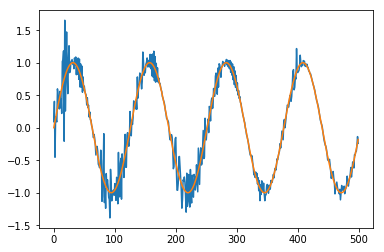

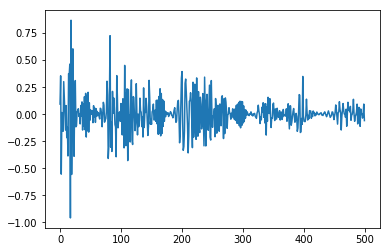

In [94]:
plt.plot(torch.cat(outs).detach().numpy())
plt.plot(torch.cat(targs).detach().numpy())
plt.show()
plt.plot(torch.cat(errs).detach().numpy())
plt.show()

In [99]:
#torch.manual_seed(1)
dt = 0.05
steps = 1000

targs = []
outs = []
errs = []

for s in range(steps):
    
    y,o = m.forward()
    outs.append(o)
    diff = o - targ(torch.tensor(dt*s))
    errs.append(diff)
    targs.append(targ(torch.tensor([dt*s])))
    
  


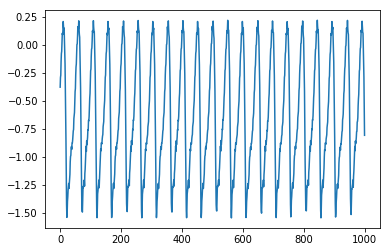

In [100]:
plt.plot(outs)
plt.show()

Compare with untrained model


In [269]:
#torch.manual_seed(-4)
n, p, sig = 100, 0.3, 0.3
m = CUDAvoir(n,p,sig)
m.ol.weight.requires_grad_(False)

dt = 0.05
steps = 1200

targs = []
outs = []
errs = []

for s in range(steps):
    
    y,o = m.forward()
    outs.append(o)
    diff = o - targ(torch.tensor(dt*s))
    errs.append(diff)
    targs.append(targ(torch.tensor([dt*s])))
    
  


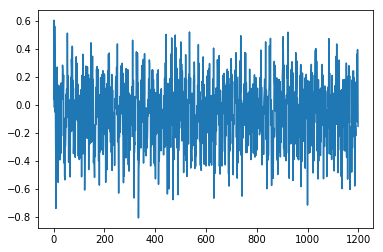

In [270]:
plt.plot(outs)
plt.show()

### Conclusions: OK, so what I did, in order, was take the model trained using your algorithm and simply ran it for the same period of time as your training epoch, but without training it. This is to test whether or not your training regime actually trained it to some sine wave, or of it just forced it to match the behavior during training by adjusting weights, but once removing error term, the network just goes back to original. When we remove the error term, we get what looks like a sine wave of different frequency, which is *exactly* what I was having trouble with with force.

### Next, I wanted to test whether the periodic behavior that seemed to be learned was actually just a product of an oscillating network, so I randomly instatiated a network and took a look. Now let's try training that same network and see if we get sine waves

In [271]:
#torch.manual_seed(1)

lr = 0.02
targ = torch.sin
dt = 0.05
steps = 500

targs = []
outs = []
errs = []

m.ol.weight.requires_grad_(True)

for s in range(steps):
    y,o = m.forward()
    outs.append(o)
    diff = o - targ(torch.tensor(dt*s))
    errs.append(diff)
    targs.append(targ(torch.tensor([dt*s])))
    
    rms = diff.pow(2)
    rms.backward(retain_graph=True)
    ol = m.ol.weight.detach()
    ol_g = m.ol.weight.grad
    nw = (ol - lr*ol_g).clone().detach()
    m.ol.weight = nn.Parameter(nw)

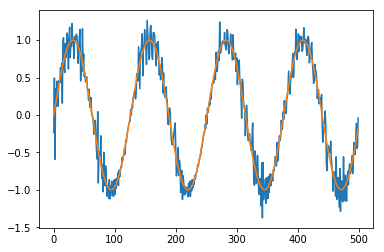

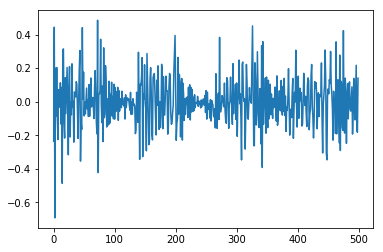

In [272]:
plt.plot(torch.cat(outs).detach().numpy())
plt.plot(torch.cat(targs).detach().numpy())
plt.show()
plt.plot(torch.cat(errs).detach().numpy())
plt.show()

In [273]:
#torch.manual_seed(1)
dt = 0.05
steps = 500

targs = []
outs = []
errs = []

for s in range(steps):
    
    y,o = m.forward()
    outs.append(o)
    diff = o - targ(torch.tensor(dt*s))
    errs.append(diff)
    targs.append(targ(torch.tensor([dt*s])))
    
  

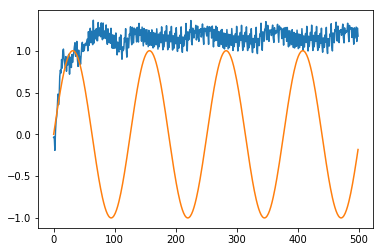

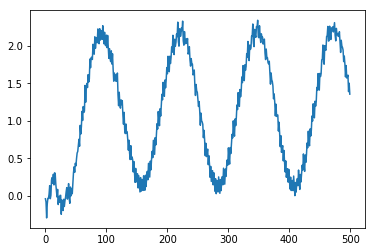

In [274]:
plt.plot(torch.cat(outs).detach().numpy())
plt.plot(torch.cat(targs).detach().numpy())
plt.show()
plt.plot(torch.cat(errs).detach().numpy())
plt.show()